
# Predicting cryptocurrency prices using AML Forecasting Toolkit

## Summary
This notebook demonstrates how to use the Azure Machine Learning (AML) Forecasting Toolkit (FTK) to forecast the value of crypte-currencies. The data we use is the [Kaggle Every Cryptocurrency Daily Market Price data](https://www.kaggle.com/jessevent/all-crypto-currencies/data). The following model development and deployment steps are implemented
* Data Ingestion: Load the data as TimeSeriesDataFrame, a time series data structure provided by the FTK.
* Feature Engineering
* Model Training and Selection: Compare the performance of naive, seasonal naive, and ARIMA, and choose the one with the best performance.
* Model Deployment: Deploy the model pipeline via Azure Machine Learning to be consumed as a web service.

**Note**:   
The notebook takes about two hours to run if run_quick is set to False and run on all 1115 stores. Set run_quick to True for a quick walk-through.

## Prerequisites
To use the deployment feature, you need to run this notebook within Azure Machine Learning Workbench. We will support deployment outside of Azure Machine Learning Workbench soon.    
For data processing and model development only, you can run the notebook outside of Azure Machine Learning Workbench.   

Follow the instructions below to install the FTK in AML Workbench and get prepared for deployment. 
1. Create an Azure Machine Learning Experimentation account, install AML Workbench, and create an AML project following [this documentation](https://docs.microsoft.com/en-us/azure/machine-learning/preview/quickstart-installation). 
2. Install Docker if you haven't. If you run into any hyper-v related issues on Windows, see [this link](https://blogs.technet.microsoft.com/canitpro/2015/09/08/step-by-step-enabling-hyper-v-for-use-on-windows-10/).
3. If you don't have kubectl.exe on your computer, download it from [here](https://storage.googleapis.com/kubernetes-release/release/v1.9.2/bin/windows/amd64/kubectl.exe) and put it under a directory that's in the system Path, e.g. C:\users\willsmith\bin\.
4. Start AML Workbench as Administrator. Open an existing project or create a new one.
5. In the toolbar, click File -> Open Command Prompt
6. Follow the environment setup instructions from our [dogfood page](https://microsoft.sharepoint.com/teams/forecastpackagedogfood/SitePages/Home.aspx).
7. To open a jupyter notebook, run ```az ml notebook start``` from the AML command prompt to open the notebook in a browser. Make sure your ftk conda environment is activated before launching the notebook. 

# Part 1
## Import Packages

In [1]:
import sys
print(sys.executable)

import pandas as pd
import numpy as np
import os

from ftk.dataframets import TimeSeriesDataFrame
from ftk.dataframeforecast import ForecastDataFrame
from ftk.pipeline import AzureMLForecastPipeline

from ftk.transforms.lagoperator import LagOperator
from ftk.transforms.rollingwindow import RollingWindow
from ftk.transforms.tsimputer import TimeSeriesImputer

from ftk.models.arima import Arima
from ftk.models.naive import SeasonalNaive, Naive

from ftk.operationalization.scorecontext import ScoreContext
from ftk.operationalization.deployment import AMLEnvironment, AMLDeployment

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\python.exe


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\dataframets.py:41: UserWarning: Unable to import .NET time series utilities. SeasonalityDetector and ExponentialSmoothingModel not available.
  + 'SeasonalityDetector and ExponentialSmoothingModel not available.')
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\models\recursiveforecaster.py:28: UserWarning: Unable to import .NET time series utilities. SeasonalityDetector and ExponentialSmoothingModel not available.
  + 'SeasonalityDetector and ExponentialSmoothingModel not available.')


In [2]:
# data = pd.read_csv(os.path.join('data', 'crypto-markets.csv'), low_memory = False, index_col = [0, 3])
# data['date'] = data['date'].astype('category')

data = pd.read_csv(os.path.join('data', 'crypto-markets.csv'), low_memory = False)

data['date'] = pd.to_datetime(data['date'])
data['open'] = data['open'].astype('float')
data['slug'] = data['slug'].astype('category')

data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32


In [3]:
data.loc[data.duplicated(['slug', 'date'])].size == 0

True

In [4]:
data.sort_index(level = ['slug', 'date'], inplace = True)

In [5]:
data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32


In [6]:
top_slugs = data.groupby('slug').size().sort_values(ascending = False).head(n = 10)

# filter only by top slugs
top_slugs_only = False
if top_slugs_only == True:
    data = data.loc[data['slug'].isin(top_slugs.index)]
    data.slug = data.slug.cat.remove_unused_categories()

In [7]:
start_dt = '2015-01-01'
end_dt = '2018-03-31'

date_range = pd.date_range(start_dt, end = end_dt, freq='D')
slug_range = pd.unique(data['slug'])

left_data = pd.DataFrame([[i, j] for i in slug_range for j in date_range], columns = ['slug', 'date'])
left_data.head()

,slug,date
0,bitcoin,2015-01-01
1,bitcoin,2015-01-02
2,bitcoin,2015-01-03
3,bitcoin,2015-01-04
4,bitcoin,2015-01-05


In [8]:
data_merged = left_data.merge(data, how = 'left', on = ['slug', 'date'])

data_merged.head()

,slug,date,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,2015-01-01,BTC,Bitcoin,1.00,320.44,320.44,314.00,314.25,8036550.00,4380820000.00,0.04,6.44
1,bitcoin,2015-01-02,BTC,Bitcoin,1.00,314.08,315.84,313.56,315.03,7860650.00,4295210000.00,0.64,2.28
2,bitcoin,2015-01-03,BTC,Bitcoin,1.00,314.85,315.15,281.08,281.08,33054400.00,4307010000.00,0.00,34.07
3,bitcoin,2015-01-04,BTC,Bitcoin,1.00,281.15,287.23,257.61,264.19,55629100.00,3847150000.00,0.22,29.62
4,bitcoin,2015-01-05,BTC,Bitcoin,1.00,265.08,278.34,265.08,274.47,43962800.00,3628490000.00,0.71,13.26


In [13]:
data_sum = data_merged.groupby('slug').describe()['open']

In [16]:
data_sum.sort_values(['count', 'mean'], ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
bitcoin,1148.00,2055.12,3531.10,176.90,291.29,606.75,1724.60,19475.80
dash,1148.00,118.92,248.09,1.08,3.10,8.65,98.92,1555.59
monero,1148.00,39.75,86.36,0.22,0.52,1.92,28.50,470.29
bitcoindark,1148.00,28.92,61.09,0.64,1.05,1.90,14.56,375.40
litecoin,1148.00,26.88,57.16,1.15,3.20,3.86,24.53,359.13


In [17]:
len(data_merged.loc[data_merged.isnull().any(axis=1)])

1158207

# Part 2

In [39]:
# change data to data_merge for clean data
data_ts = TimeSeriesDataFrame(data, grain_colnames = ['slug'], time_colname = 'date', ts_value_colname = 'open')
data_ts.head()

,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,slug,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32


In [40]:
%matplotlib inline
# data_ts.ts_summary()

In [41]:
cutoff_dt = '2017-12-31'

train_ts = data_ts.loc[(data_ts.time_index <= cutoff_dt) & (data_ts.time_index >= start_dt)]
test_ts = data_ts.loc[data_ts.time_index > cutoff_dt]

In [42]:
freq_to_slug = train_ts.get_frequency_dict()
{k:len(freq_to_slug[k]) for k in freq_to_slug.keys()}

{'B': 13, 'D': 770, 'None': 523}

In [98]:
# frequency distribution
slug_size = train_ts.groupby('slug').size().to_dict()
slug_to_freq = {v: (k, slug_size[v]) for k, w in freq_to_slug.items() for v in w}

def freq_dist(freq):
    x = np.unique([slug_size[slug] for slug in freq_to_slug[freq]], return_counts = True)
    return(pd.DataFrame({'freq':freq, 'size':x[0], 'count':x[1]}))

# freq_dist('None')

freqs = pd.concat([freq_dist(freq) for freq in freq_to_slug.keys()])
freqs.sort_values(['size', 'freq'], ascending = False).head(10)

,count,freq,size
290,101,D,1096
380,9,None,1095
379,3,None,1094
10,2,B,1094
378,3,None,1093
377,2,None,1092
376,4,None,1091
375,4,None,1090
374,2,None,1089
373,1,None,1088


In [99]:
clean_slugs_only = True
freq_val = []
freq_len = 1094

if clean_slugs_only == True:
    clean_slugs = [k for k, v in slug_to_freq.items() if (v[0] in freq_val if len(freq_val) > 0 else True) and (v[1] == freq_len if freq_len > 0 else True)]
    train_tss = train_ts.loc[train_ts.grain_index.isin(clean_slugs)]    
    test_tss = test_ts.loc[test_ts.grain_index.isin(clean_slugs)]

train_tss.head()

,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,slug,,,,,,,,,,,
2015-01-01,diamond,DMD,Diamond,244,0.18,0.25,0.18,0.21,3267,140811,0.45,0.07
2015-01-02,diamond,DMD,Diamond,244,0.21,0.26,0.20,0.26,1271,161729,1.00,0.06
2015-01-03,diamond,DMD,Diamond,244,0.26,0.27,0.17,0.17,1434,204738,0.00,0.10
2015-01-04,diamond,DMD,Diamond,244,0.17,0.18,0.16,0.16,576,132417,0.19,0.02
2015-01-05,diamond,DMD,Diamond,244,0.16,0.18,0.16,0.16,690,129597,0.30,0.02


In [106]:
[slug_to_freq[s][0] for s in clean_slugs]

['None', 'B', 'None', 'B', 'None']

In [135]:
tss = train_tss.groupby(train_tss.index.get_level_values(1).remove_unused_categories()).describe()
tss['open'].head()

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
cryptogenic-bullion,1094.00,0.38,0.56,0.03,0.09,0.16,0.26,3.27
diamond,1094.00,1.66,3.45,0.09,0.24,0.29,0.51,19.98
pinkcoin,1094.00,0.01,0.01,0.00,0.00,0.00,0.00,0.06
trollcoin,1094.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
zeitcoin,1094.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [108]:
# Use a TimeSeriesImputer to forward fill values at missing days
imputer = TimeSeriesImputer(input_column = 'open', 
                            option = 'fillna',
                            method = 'ffill',
                            freq = 'D')

# imputed_ts = imputer.transform(train_ts.loc[train_ts.grain_index.isin(freq_to_slug['D'][:2])])
imputed_tss = imputer.transform(train_tss)

imputed_tss.head()

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\dataframets.py:1102: UserWarning: Failed to infer a frequency for 3 of the time series
  UserWarning)


,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,slug,,,,,,,,,,,
2015-01-01,cryptogenic-bullion,CBX,Crypto Bullion,633.00,0.07,0.07,0.06,0.06,8.00,62668.00,0.11,0.01
2015-01-02,cryptogenic-bullion,CBX,Crypto Bullion,633.00,0.06,0.07,0.05,0.06,140.00,57453.00,0.43,0.01
2015-01-03,cryptogenic-bullion,CBX,Crypto Bullion,633.00,0.06,0.07,0.05,0.05,57.00,57770.00,0.04,0.01
2015-01-04,cryptogenic-bullion,CBX,Crypto Bullion,633.00,0.05,0.05,0.05,0.05,52.00,49628.00,0.39,0.01
2015-01-05,cryptogenic-bullion,CBX,Crypto Bullion,633.00,0.05,0.05,0.05,0.05,13.00,48731.00,0.60,0.00


In [109]:
len(imputed_tss) - len(train_tss)

10

In [113]:
#! imputed_tss.reset_index().head()

In [126]:
idx = [['2017-01-04', slug] for slug in train_tss.index.get_level_values(1).remove_unused_categories().categories]
idx
# imputed_tss.loc[idx, :]

[['2017-01-04', 'cryptogenic-bullion'],
 ['2017-01-04', 'diamond'],
 ['2017-01-04', 'pinkcoin'],
 ['2017-01-04', 'trollcoin'],
 ['2017-01-04', 'zeitcoin']]

In [127]:
# train_tss.index.levels[1] = train_tss.index.get_level_values(1).remove_unused_categories()

------------------------------------------  Data Overview  -------------------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 5480 entries, (2015-01-01 00:00:00, cryptogenic-bullion) to (2017-12-31 00:00:00, zeitcoin)
Data columns (total 11 columns):
symbol         5470 non-null object
name           5470 non-null object
ranknow        5470 non-null float64
open           5480 non-null float64
high           5470 non-null float64
low            5470 non-null float64
close          5470 non-null float64
volume         5470 non-null float64
market         5470 non-null float64
close_ratio    5470 non-null float64
spread         5470 non-null float64
dtypes: float64(9), object(2)
memory usage: 695.7+ KB
------------------------------------  Numerical Variable Summary  ------------------------------------
       ranknow    open    high     low   close     volume      market  \
count  5470.00 5480.00 5470.00 5470.00 5470.00    5470.00     5470.00   
mean  

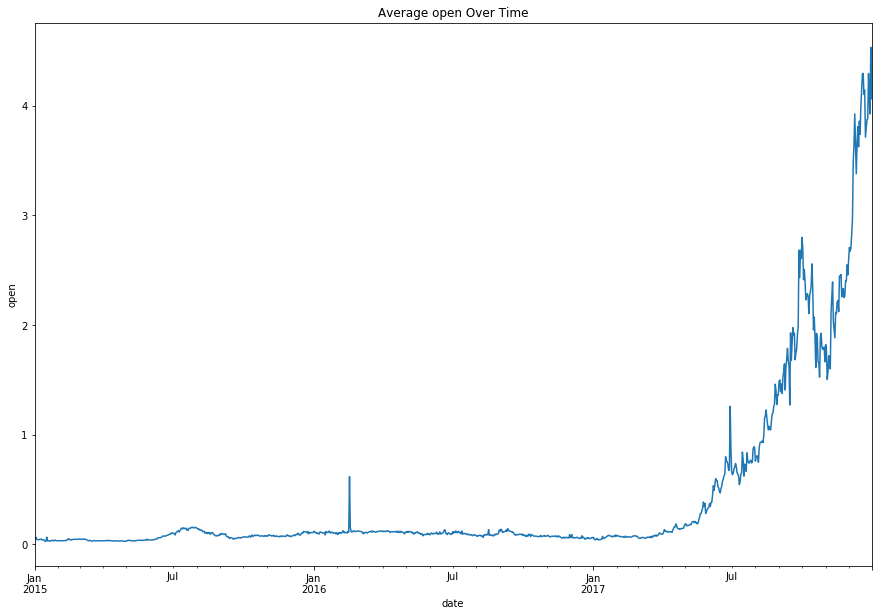

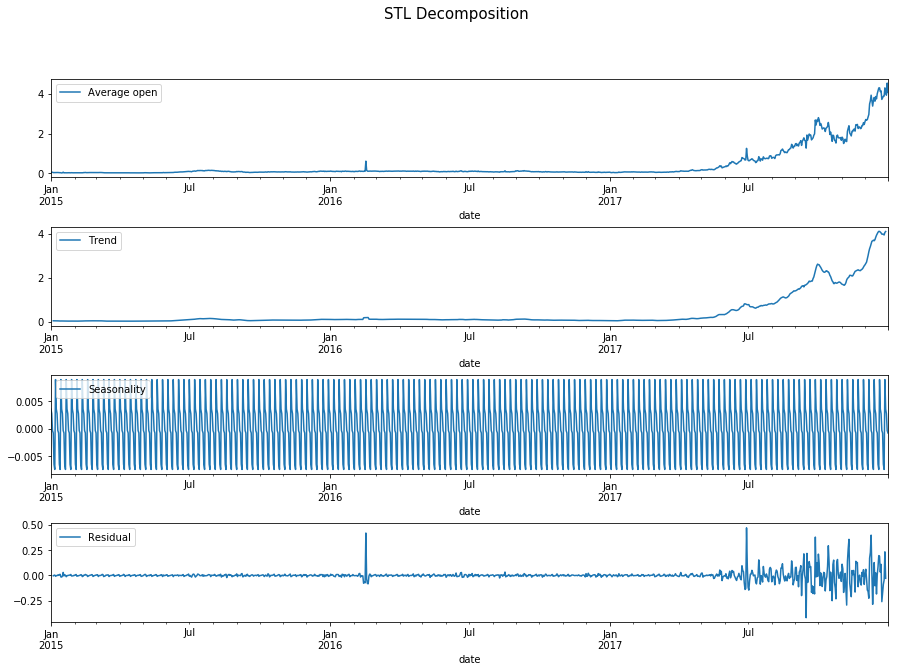

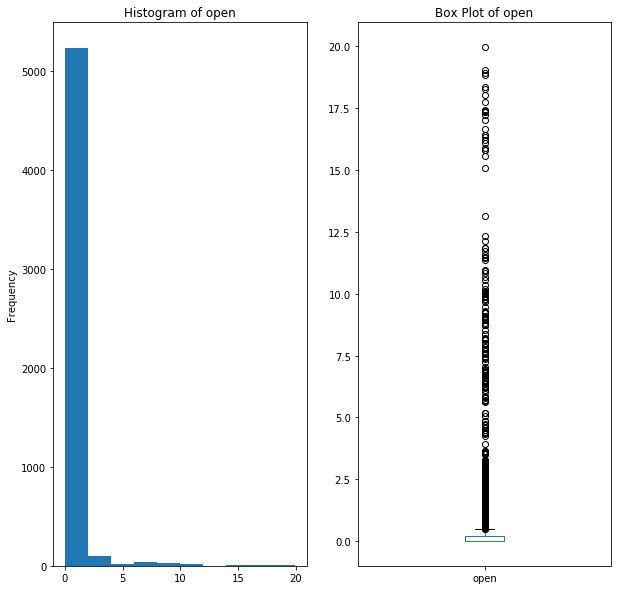

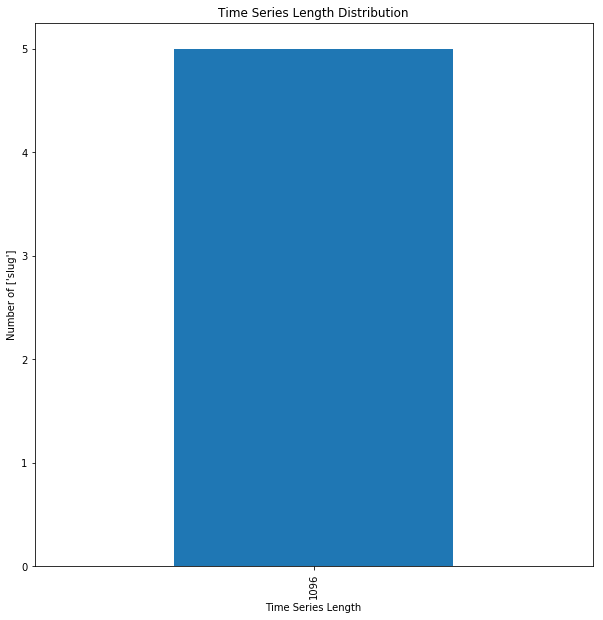

In [136]:
imputed_tss.ts_summary()

# next section

We found store 13 has half a year of missing data from 2014-07-01 to 2014-12-31. It turned out this is the case for all 180 stores for which the frequency can not be inferred. 

There is no easy way to fix this in reality. For the purpose of generating predictions for the competition, we fill this gap  an imputation transform that is equivalent to a naive forecast on the missing dates.


Now, all time series are regular with a daily frequency:

## Feature Engineering

### Create and Test Data Transformers
**Note**: Currently, we only use univariate time series models. Therefore, the transfomers are created and tested for
demonstration purpose only. 

In [137]:
# Create transformers
rolling_transformer = RollingWindow(window_size=3, transform_dict={'mean': ['open', 'close']})
lag_transformer = LagOperator(lags_to_construct=3, columns_to_lag='open')

# check transformer output
transformed_ts = rolling_transformer.transform(imputed_tss)
transformed_ts = lag_transformer.transform(transformed_ts)
transformed_ts.head()

symbol            name  ranknow  open  high  \
date       slug                                                              
2015-01-01 cryptogenic-bullion    CBX  Crypto Bullion   633.00  0.07  0.07   
           diamond                DMD         Diamond   244.00  0.18  0.25   
           pinkcoin              PINK        PinkCoin   455.00  0.00  0.00   
           trollcoin            TROLL       Trollcoin   999.00  0.00  0.00   
           zeitcoin              ZEIT        Zeitcoin   520.00  0.00  0.00   

                                low  close  volume    market  close_ratio  \
date       slug                                                             
2015-01-01 cryptogenic-bullion 0.06   0.06    8.00  62668.00         0.11   
           diamond             0.18   0.21 3267.00 140811.00         0.45   
           pinkcoin            0.00   0.00  148.00 110231.00         0.07   
           trollcoin           0.00   0.00   23.00  10911.00         1.00   
           zeitcoin            0.00   0.00  105.00  63118.00         0.00   

                                spread  close_mean_window3  open_mean_window3  \
date       slug                                                                 
2015-01-01 cryptogenic-bullion    0.01                 nan                nan   
           diamond                0.07                 nan                nan   
           pinkcoin               0.00                 nan                nan   
           trollcoin              0.00                 nan                nan   
           zeitcoin               0.00                 nan                nan   

                                open_lag3  
date       slug                            
2015-01-01 cryptogenic-bullion        nan  
           diamond                    nan  
           pinkcoin                   nan  
           trollcoin                  nan  
           zeitcoin                   nan

In [139]:
transformed_ts.loc[('2017-01-01', 'bitcoin'):('2017-01-02', 'bitcoin'), :]

symbol            name  ranknow  open  high  \
date       slug                                                              
2017-01-01 cryptogenic-bullion    CBX  Crypto Bullion   633.00  0.11  0.11   
           diamond                DMD         Diamond   244.00  0.22  0.22   
           pinkcoin              PINK        PinkCoin   455.00  0.00  0.00   
           trollcoin            TROLL       Trollcoin   999.00  0.00  0.00   
           zeitcoin              ZEIT        Zeitcoin   520.00  0.00  0.00   

                                low  close  volume    market  close_ratio  \
date       slug                                                             
2017-01-01 cryptogenic-bullion 0.10   0.11   18.00 105233.00         0.49   
           diamond             0.15   0.15 3152.00 414930.00         0.00   
           pinkcoin            0.00   0.00  477.00 172744.00         0.03   
           trollcoin           0.00   0.00    1.00  20098.00         1.00   
           zeitcoin            0.00   0.00   53.00 288770.00         0.50   

                                spread  close_mean_window3  open_mean_window3  \
date       slug                                                                 
2017-01-01 cryptogenic-bullion    0.01                0.10               0.10   
           diamond                0.07                0.19               0.21   
           pinkcoin               0.00                0.00               0.00   
           trollcoin              0.00                0.00               0.00   
           zeitcoin               0.00                0.00               0.00   

                                open_lag3  
date       slug                            
2017-01-01 cryptogenic-bullion       0.08  
           diamond                   0.21  
           pinkcoin                  0.00  
           trollcoin                 0.00  
           zeitcoin                  0.00

## Model Training and Validation
Split training data into train and validate datasets

In [148]:
val_cutoff_dt = '2017-09-01'
validate_ts = imputed_tss.loc[imputed_tss.time_index >= val_cutoff_dt]
train_ts = imputed_tss.loc[imputed_tss.time_index < val_cutoff_dt]

### Initialize Models

Based on the inferred frequency and seasonality, we set the following model parameters. 

In [149]:
# Model parameters
series_freq = 'D'
series_seasonality = 7

In [150]:
# Initialize naive model
naive_model = Naive(freq = series_freq)

# Initialize seasonal naive model
seasonal_naive_model = SeasonalNaive(freq = series_freq, 
                                     seasonality = series_seasonality)

# Initialize ARIMA(p,d,q) model
arima_order = [2,1,0]
arima_model = Arima(series_freq, arima_order)

### Build the Pipelines

In [151]:
pipeline_naive = AzureMLForecastPipeline([('naive_model', naive_model)])
pipeline_seasonal_naive = AzureMLForecastPipeline([('seasonal_naive_model', seasonal_naive_model)])
pipeline_arima = AzureMLForecastPipeline([('arima_model', arima_model)])

### Fit the Pipelines

In [152]:
pipeline_naive = pipeline_naive.fit(train_ts)
pipeline_seasonal_naive = pipeline_seasonal_naive.fit(train_ts)
pipeline_arima = pipeline_arima.fit(train_ts)

F1 2018-04-04 16:00:44,248 INFO azureml.timeseries - pipeline fit started. 
F1 2018-04-04 16:00:44,364 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:00.115989
F1 2018-04-04 16:00:44,380 INFO azureml.timeseries - pipeline fit started. 
F1 2018-04-04 16:00:44,464 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:00.084694
F1 2018-04-04 16:00:44,480 INFO azureml.timeseries - pipeline fit started. 


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


F1 2018-04-04 16:00:45,035 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:00.554747


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Predict and Evaluate Model Performances

In [153]:
validate_predicted_naive = pipeline_naive.predict(validate_ts)
validate_predicted_seasonal_naive = pipeline_seasonal_naive.predict(validate_ts)
validate_predicted_arima = pipeline_arima.predict(validate_ts)

validate_error_naive = validate_predicted_naive.calc_error()
validate_error_seasonal_naive = validate_predicted_seasonal_naive.calc_error()
validate_error_arima = validate_predicted_arima.calc_error()

print('Naive model MAPE: {0}'.format(validate_error_naive))
print('Seasonal naive model MAPE: {0}'.format(validate_error_seasonal_naive))
print('ARIMA model MAPE: {0}'.format(validate_error_arima))

F1 2018-04-04 16:00:48,994 INFO azureml.timeseries - pipeline predict started. 
F1 2018-04-04 16:00:49,549 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:00.554369
F1 2018-04-04 16:00:49,564 INFO azureml.timeseries - pipeline predict started. 
F1 2018-04-04 16:00:50,096 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:00.531943
F1 2018-04-04 16:00:50,096 INFO azureml.timeseries - pipeline predict started. 


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


F1 2018-04-04 16:00:50,835 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:00.739141
Naive model MAPE: 33.48651136031168
Seasonal naive model MAPE: 34.363311420668126
ARIMA model MAPE: 34.574439301747596


The model evaluation results above show that the Seasonal Naive model outperforms the two three models. We will fit a Seasonal Naive model on all the training data and score the trained model on test data. 

In [155]:
pipeline_seasonal_naive.fit(pd.concat([train_ts, validate_ts]))
forecast_all_seasonal_naive = pipeline_seasonal_naive.predict(test_tss)
forecast_all_seasonal_naive.head()

F1 2018-04-04 16:01:18,704 INFO azureml.timeseries - pipeline fit started. 
F1 2018-04-04 16:01:18,820 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:00.115899
F1 2018-04-04 16:01:18,835 INFO azureml.timeseries - pipeline predict started. 
F1 2018-04-04 16:01:19,268 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:00.432411


,,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,DistributionForecastSeasonalNaive,PointForecastSeasonalNaive
date,slug,ForecastOriginDate,,,,,,,,,,,,,
2018-01-01,cryptogenic-bullion,2017-12-31,CBX,Crypto Bullion,633,2.25,2.74,2.21,2.40,2219,2267550,0.36,0.53,<scipy.stats._distn_infrastructure.rv_frozen o...,2.07
2018-01-02,cryptogenic-bullion,2017-12-31,CBX,Crypto Bullion,633,2.40,4.17,2.40,3.56,14287,2415000,0.66,1.77,<scipy.stats._distn_infrastructure.rv_frozen o...,1.92
2018-01-03,cryptogenic-bullion,2017-12-31,CBX,Crypto Bullion,633,3.55,4.67,3.47,3.84,3635,3570970,0.31,1.20,<scipy.stats._distn_infrastructure.rv_frozen o...,2.58
2018-01-04,cryptogenic-bullion,2017-12-31,CBX,Crypto Bullion,633,3.86,4.44,3.75,3.84,10967,3889590,0.13,0.69,<scipy.stats._distn_infrastructure.rv_frozen o...,2.22
2018-01-05,cryptogenic-bullion,2017-12-31,CBX,Crypto Bullion,633,3.84,5.51,3.80,5.48,16362,3868870,0.98,1.71,<scipy.stats._distn_infrastructure.rv_frozen o...,2.24


In [158]:
diff = forecast_all_seasonal_naive['open'] - forecast_all_seasonal_naive['PointForecastSeasonalNaive']
diff.groupby(forecast_all_seasonal_naive.index.get_level_values(1).remove_unused_categories()).describe()

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
cryptogenic-bullion,52.00,1.95,1.29,-0.27,0.98,1.73,2.64,4.77
diamond,52.00,1.32,6.20,-7.25,-3.50,0.49,7.36,14.14
pinkcoin,52.00,-0.01,0.02,-0.03,-0.02,-0.01,0.00,0.05
trollcoin,52.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
zeitcoin,52.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Operationalization
In this section, we will deploy a pipeline as a Azure Machine Learning web service and use it for training and scoring. 
Currently, the following two workflows are available:
1. Deploy a pipeline that's not fitted as a web service. Call the web service to do both training and scoring.
2. Deploy a fitted pipeline. Call the web service to score only.

### Set model deployment parameters
Please change the following parameters to your own values. Make sure your AML environment, model management account, and resource group are located in the sam region. 

In [159]:
azure_subscription = '5be49961-ea44-42ec-8021-b728be90d58c'

# If cluster is True, create a Azure Container Service cluster and deploy the web service there.
# If False, deploy the "web service" locally.
# Cluste deployment takes about 20 minutes and local takes about 5 minutes. 
cluster = False

# The AML environment name. This could be an existing AML environment or a new AML environment to be created automatically.
aml_env_name = 'cryptocurrencyenv'

# The resource group that contains the Azure resources related to the AML environment.
aml_env_resource_group = 'sethmottftktest'

# The location where the Azure resources related to the AML environment are located at.
aml_env_location = 'westcentralus'

# The AML model management account name. This could be an existing model management account a new model management 
# account to be created automatically. 
model_management_account_name = 'sethmottmlmm'

# The resource group that contains the Azure resources related to the model management account.
model_management_account_resource_group = 'sethmottbc'

# The location where the Azure resources related to the model management account are located at.
model_management_account_location = 'eastus2'

# The name of the deployment/web service.
deployment_name = 'sethmottftkserv'

# The directory to store deployment related files, such as pipeline pickle file, score script, and conda dependencies file. 
deployment_working_directory = 'C:\\Users\\sethmott\\ftk'

### Define the AML environment and deployment

In [161]:
aml_env = AMLEnvironment(env_name=aml_env_name, 
                         env_resource_group=aml_env_resource_group,
                         env_location=aml_env_location, 
                         azure_subscription=azure_subscription,
                         model_management_account_name=model_management_account_name, 
                         model_management_account_resource_group=model_management_account_resource_group,
                         model_management_account_location=model_management_account_location,
                         cluster=cluster)

snaive_model = SeasonalNaive(freq=series_freq, seasonality=series_seasonality)
pipeline_snaive = AzureMLForecastPipeline([('seasonal_naive_model', snaive_model)])
aml_deployment = AMLDeployment(aml_env=aml_env, 
                               deployment_name=deployment_name,
                               pipeline=pipeline_snaive,
                               deployment_working_directory=deployment_working_directory)

### Create the web service

In [164]:
# This step can take 5 to 20 minutes
# NOTE: Currently, recreate=False is not supported for deploying to ACS clusters
aml_deployment.deploy()

running az account set --subscription 5be49961-ea44-42ec-8021-b728be90d58c
running az ml account modelmanagement list


Exception: Failed to run command az ml account modelmanagement list with error ERROR: No module named 'azureml.api'
Traceback (most recent call last):
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\knack\cli.py", line 194, in invoke
    cmd_result = self.invocation.execute(args)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\azure\cli\core\commands\__init__.py", line 255, in execute
    self.commands_loader.load_arguments(command)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\azure\cli\core\__init__.py", line 201, in load_arguments
    self.command_table[command].load_arguments()  # this loads the arguments via reflection
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\azure\cli\core\commands\__init__.py", line 148, in load_arguments
    super(AzCliCommand, self).load_arguments()
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\knack\commands.py", line 76, in load_arguments
    cmd_args = self.arguments_loader()
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\azure\cli\core\__init__.py", line 353, in default_arguments_loader
    op = handler or self.get_op_handler(operation)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\site-packages\azure\cli\core\__init__.py", line 397, in get_op_handler
    op = import_module(mod_to_import)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 985, in _gcd_import
  File "<frozen importlib._bootstrap>", line 968, in _find_and_load
  File "<frozen importlib._bootstrap>", line 957, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 673, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 697, in exec_module
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "C:\Users\sethmott\.azure\cliextensions\azure-cli-ml\azext_ml\model_management_account.py", line 20, in <module>
    from ._az_util import az_register_provider
  File "C:\Users\sethmott\.azure\cliextensions\azure-cli-ml\azext_ml\_az_util.py", line 25, in <module>
    from ._util import cli_context
  File "C:\Users\sethmott\.azure\cliextensions\azure-cli-ml\azext_ml\_util.py", line 49, in <module>
    from azureml.api.realtime.services import generate_main
ImportError: No module named 'azureml.api'


### Score and evaluate web service
To score a small dataset, use the score method to submit one web service call for all the data. 

In [ ]:
# Need to add empty prediction columns to the validation data frame 
# and create a ForecastDataFram
validate_ts = validate_ts.assign(SeasonalNaivePointForecast=0.0,
                                 SeasonalNaiveDistributionForecast=np.nan)
validate_fcst = ForecastDataFrame(validate_ts, pred_point='SeasonalNaivePointForecast',
                                 pred_dist='SeasonalNaiveDistributionForecast')

# Define Score Context
# This is for deploying a pipeline not fitted yet.
score_context = ScoreContext(input_training_data_tsdf=train_ts, 
                             input_scoring_data_fcdf=validate_fcst, 
                             pipeline_execution_type='train_predict')

# If deploying a fitted pipeline use the following score_context
# score_context = ScoreContext(input_scoring_data_fcdf=input_scoring_data_df, 
#                             pipeline_execution_type='predict_only') 

# Get deployed web service
aml_web_service = aml_deployment.get_deployment()

# Score the web service
results = aml_web_service.score(score_context=score_context)
print(type(results))
print(results)

# Evaluate result
webservice_error = results.calc_error()
print('Seasonal naive model MAPE:{0}'.format(webservice_error))

To score a large dataset, use the score_driver method to submit multiple web service calls, one for each unique value of
group_col. 

In [ ]:
# Call the forecast service once for each store in the validation set
results = aml_web_service.score_driver(score_context=score_context, group_col='Store')

# Calculate the forecasting errors for store time series
webservice_fcst_errors = results.calc_error(by='Store')
webservice_fcst_errors